In [1]:
import os
import gnssrefl.gps as g
import gnssrefl.rinex2snr as rnx
import gnssrefl.quickLook_function as quick
import gnssrefl.gnssir as guts
import json
import pandas as pd 
import check_parameters
import requests
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style="whitegrid");
import re
from datetime import datetime
import numpy as np

# making sure that env variables are set - if they are then nothing will print to screen
g.check_environ_variables()

%matplotlib inline

EXE  not found, so set to current directory
ORBITS  not found, so set to current directory
REFL_CODE  not found, so set to current directory


### Marshall, Colorado, USA

**Station Name:** p041 

**Location:** Boulder, CO, USA

**Archive:** [UNAVCO](http://www.unavco.org)

**DOI:**  	[https://doi.org/10.7283/T5R49NQQ](https://doi.org/10.7283/T5R49NQQ)

**Ellipsoidal Coordinates:**

- Latitude: 39.94949

- Longitude: -105.19427

- Height: 1728.842 m

[Station Page at UNAVCO](https://www.unavco.org/instrumentation/networks/status/nota/overview/P041)

[Station Page at Nevada Geodetic Laboratory](http://geodesy.unr.edu/NGLStationPages/stations/P041.sta)

[Google Map Link](https://goo.gl/maps/GwGV8PS4CQVQzYHC7) 

<img src="https://gnss-reflections.org/static/images/P041.jpg" width="500">

## Data Summary

The p041 antenna is ~2 meters above the soil surface. It is located at Marshall Mesa, Colorado.
The site is relatively planar and free of obstructions. Since October 2018 the site has 
recorded multi-GNSS signals. Marshall Mesa has been featured in multiple publications on GNSS-IR:

* [Use of GPS Receivers as a Soil Moisture Network for Water Cycle Studies (2008)](https://www.kristinelarson.net/wp-content/uploads/2015/10/larson_soil_grl2008.pdf)

* [Can We Measure Snow Depth with GPS Receivers (2009)](https://www.kristinelarson.net/wp-content/uploads/2015/10/larsonetal_snow_2009.pdf) 

* [Sensing Vegetation Growth with Reflected GPS Signals (2010)](https://www.kristinelarson.net/wp-content/uploads/2015/10/small_etal_2010.pdf) 

To get a sense of whether an azimuth or elevation mask is appropriate, 
check the [Reflection Zone Mapping in the web app](https://gnss-reflections.org/rzones?station=p041&lat=39.9495&lon=-105.1943&height=1728.842&msl=on&RH=2&eang=2&azim1=0&azim2=360).  
In the linked page, the reflection zones from 5 to 25 degree elevation angles are plotted as 
colored ellipses surrounding the station.  

### Web App

More information on the station can be obtained from the GNSS-IR Web App, where p041 is one of the example cases for soil moisture and snow depth. [Please note that the app will be analyzing data in real-time, so please wait for the periodogram to appear on the left side of the page. It takes about 5 seconds](https://gnss-reflections.org/fancy6?example=p041). The web app will return a photograph, station coordinates, a Google Earth Map, and a sample periodogram. The periodogram plots the reflector height (RH) in four quadrants (NW, NE, SW, SE), allowing the reflection characteristics and quality of the site to be inferred. For example, variations in topography or buildings blocking the reflections could all affect the periodograms.

In [2]:
%%html
<iframe src="https://gnss-reflections.org/api?example=p041" width="1000" height="900"></iframe>

### Setting Azimuth and Elevation Mask

To get a sense of whether an azimuth or elevation mask is appropriate, check the [Reflection Zone Mapping in the web app](https://gnss-reflections.org/rzones?station=p041&lat=39.9495&lon=-105.1943&height=1728.842&msl=on&RH=2&eang=2&azim1=0&azim2=360).  
In the linked page, the reflection zones at 5, 10, and 15-degree elevation angles are plotted as colored ellipses surrounding the station, all overlaid on a Google Earth map.  Higher elevation angles are closer to the station.
As can be seen from the Google Earth map, this site is relatively flat with no major obstacles to interfere with reflected signals.  Therefore the elevation angles can be left at default settings and no azimuth masks are required.

In [4]:
%%html
<iframe src="https://gnss-reflections.org/rzones?station=p041&lat=39.9495&lon=-105.1943&height=1728.842&msl=on&RH=2&eang=2&azim1=0&azim2=360" width="950" height="500"></iframe>

### Make SNR File

Begin by making an SNR file.

In [4]:
station = 'p041'
year = 2020 
doy = 132

lat = 39.9495
long = -105.1943
height = 1728.856

In [ ]:
# Can view the parameters here
check_parameters.rinex2snr?

In [5]:
args = check_parameters.rinex2snr(station,year,doy, translator='hybrid')
rnx.run_rinex2snr(**args)

SNR file exists ./2020/snr/p041/p0411320.20.snr66


### Take a Quick Look at the Data

Then use **quickLook** to analyze the reflection characteristics of the site [(For details on quickLook output)](../../docs/quickLook_desc.md).

The default return is for the L1 frequency:

In [27]:
# making a plotting function for the quicklook function
def quicklook_results(args, values):
    freq = {1:'L1', 20: 'L2C', 5:'L5'}
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
    quadrants = ['NW', 'NE', 'SW', 'SE']
    axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    for i, quadrant in enumerate(quadrants):
        satellites = values[quadrant].keys()
        fail_satellites = values[f'f{quadrant}'].keys()

        for failsat in fail_satellites:
            axes[i].plot(values[f'f{quadrant}'][failsat][0], values[f'f{quadrant}'][failsat][1], color='lightgrey') 
        for sat in satellites:
            axes[i].plot(values[quadrant][sat][0], values[quadrant][sat][1])

    ax[0,0].set_title('Northwest', size=14)
    ax[0,1].set_title('Northeast',size=14)
    ax[1,0].set_title('Southwest', size=14)
    ax[1,1].set_title('Southeast', size=14)

    for ax in axes:
        ax.set_xlabel('reflector height (m)', size=14)
        ax.set_ylabel('volts/volts', size=14)
        ax.grid()
    
    fig.suptitle(f'GNSS Station {args["station"].upper()}, {args["year"]} doy {args["doy"]}, freq {freq[args["f"]]}, elevation angles {args["e1"]}-{args["e2"]} \n', size=16)
    fig.tight_layout()
    plt.show()
    
    
def quicklook_metrics(args, values):
#     fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
    quadrants = ['NW', 'NE', 'SW', 'SE']
    
    # re-organizing the data in a plotting friendly format
    success_data = {'Azimuth': [], 'Reflector Height': [], 'Peak to Noise':[], 'Amplitude': []}
    fail_data =  {'Azimuth': [], 'Reflector Height': [], 'Peak to Noise': [], 'Amplitude': []}
    
    for i, quadrant in enumerate(quadrants):
        for j in values[quadrant].keys():
            success_data['Azimuth'].append(datakeys[quadrant][j][0])
            success_data['Reflector Height'].append(datakeys[quadrant][j][1])
            success_data['Peak to Noise'].append(datakeys[quadrant][j][5])
            success_data['Amplitude'].append(datakeys[quadrant][j][4])
        for k in values[f'f{quadrant}'].keys():
            fail_data['Azimuth'].append(datakeys[f'f{quadrant}'][k][0])
            fail_data['Reflector Height'].append(datakeys[f'f{quadrant}'][k][1])
            fail_data['Peak to Noise'].append(datakeys[f'f{quadrant}'][k][5])
            fail_data['Amplitude'].append(datakeys[f'f{quadrant}'][k][4])

    return pd.DataFrame(success_data), pd.DataFrame(fail_data)   

minimum elevation angle (degrees) for this dataset:  0.0007


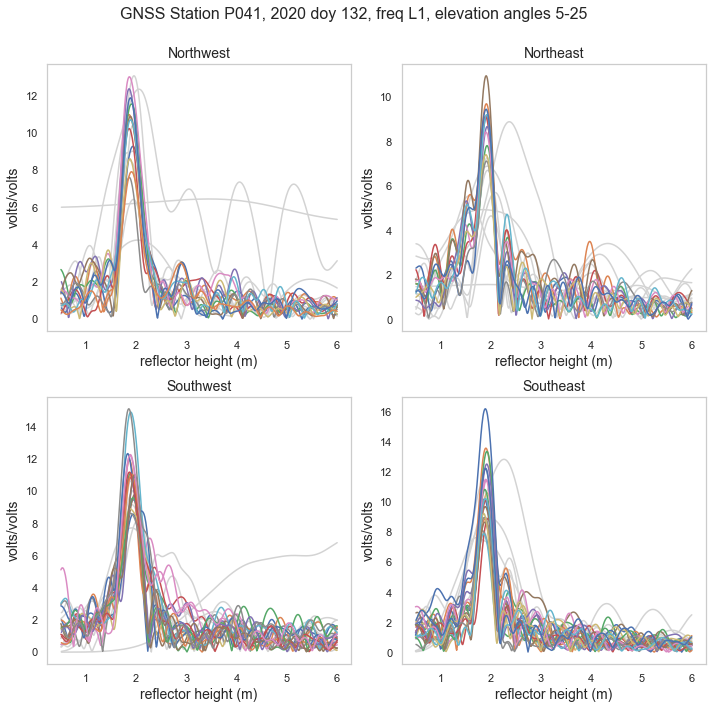

In [28]:
args = check_parameters.quicklook(station, year, doy=doy)
values, datakeys = quick.quickLook_function(**args)
quicklook_results(args, values)

Now try looking at the periodogram for L2C:

minimum elevation angle (degrees) for this dataset:  0.0007


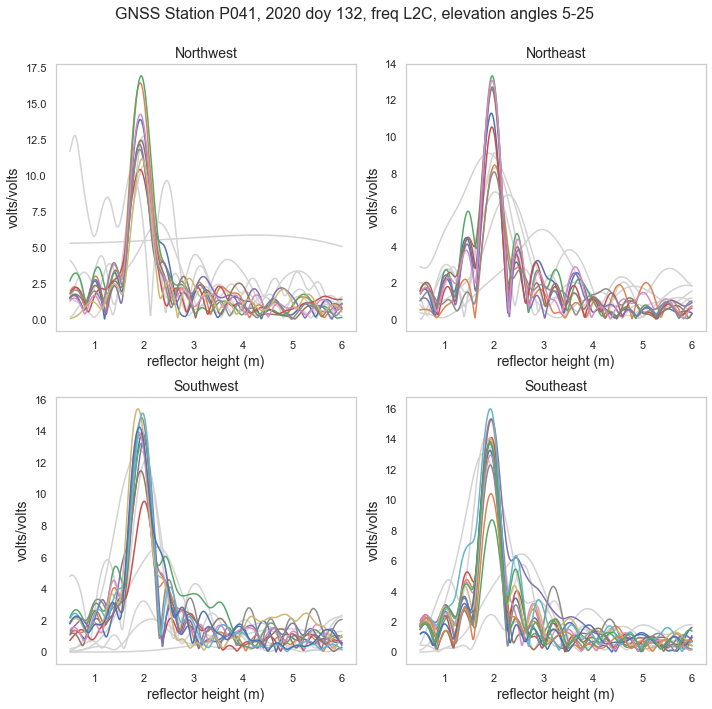

In [13]:
args = check_parameters.quicklook(station, year, doy=doy, f=20)
values, datakeys = quick.quickLook_function(**args)
quicklook_results(args, values)

Note that there are more colors in the L1 plots than in the L2C plots. That is the result of the fact that there are more L1 satellites than L2C satellites.

Now try L5:

minimum elevation angle (degrees) for this dataset:  0.0007


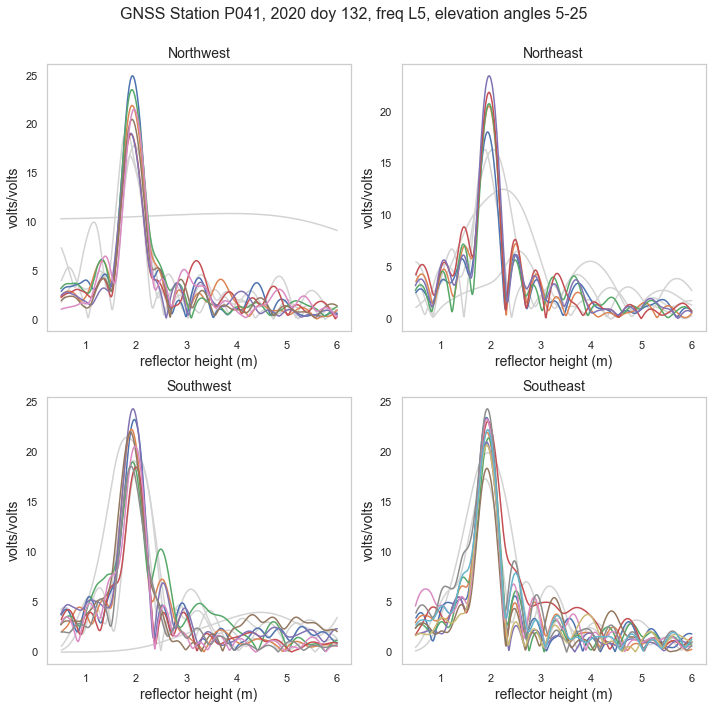

In [16]:
args = check_parameters.quicklook(station, year, doy=doy, f=5)
values, datakeys = quick.quickLook_function(**args)
quicklook_results(args, values)

The L5 signal has only been available on satellites launched after 2010, so there are
fewer satellite tracks than either L1 or L2C.

The *quickLook* code has multiple options. For example, it is possible change the reflector height range:

minimum elevation angle (degrees) for this dataset:  0.0007


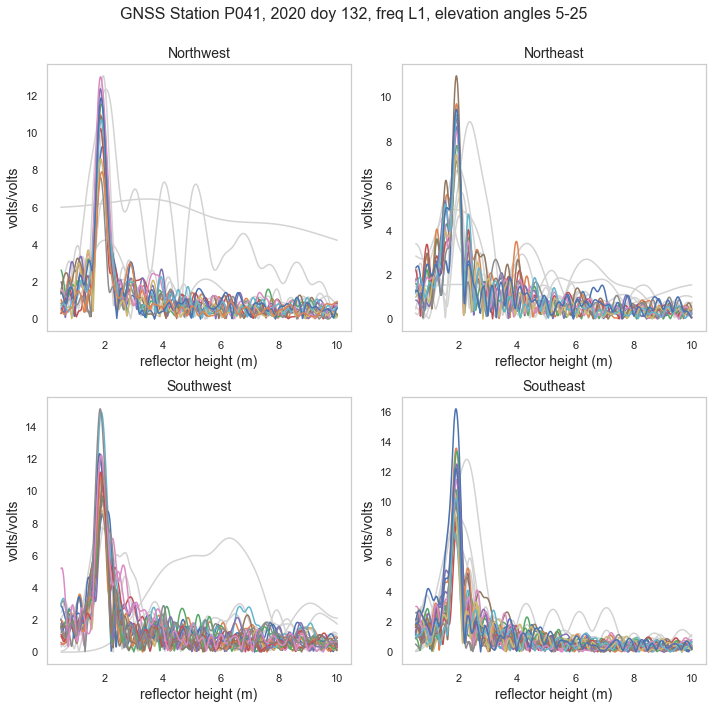

In [18]:
args = check_parameters.quicklook(station, year, doy=doy, h1=0.5, h2=10)
values, datakeys = quick.quickLook_function(**args)
quicklook_results(args, values)

To look at Glonass and Galileo signals, the SNR files must be created using the -orb gnss flag.
If you have already made a file using only the GPS data, you will need the overwrite flag.

In [23]:
# # need to remove old file otherwise, it will see the file exists and not create a new one with the new parameters
#os.remove('2020/snr/p041/p0411320.20.snr66')
args = check_parameters.rinex2snr(station, year, doy, orb='gnss', overwrite=True, translator='fortran')
rnx.run_rinex2snr(**args)

Will seek RINEX file  p041  year: 2020  doy: 132  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0411320.20.snr66


Beidou signals are tracked at this site, but unfortunately the data are not available in the RINEX 2.11 file.
They are very likely available in the RINEX 3 file, so you are encouraged to look there.

**quickLook** is meant to be a visual assessment of the spectral characteristics at a given site on a given day. For routine analysis, one must use  **gnssir**.

## Analyze the Data

We will start by setting up the analysis parameters. These are stored
in a json file. In this case, the p041 RINEX data are multi-gnss, so you could
set the options to allow all frequencies from all constellations by setting the parameter allfreq=True.

We are going to concentrate on GPS-only, which is the default. We have set stricter QC values by
setting the amplitude minimum to 8 and the peak 2 noise ratio to 3.2:

In [24]:
# Here we can see what parameters are available and what the defaults are:
check_parameters.make_json?

In [25]:
# we saved the lat, long, and height earlier
check_parameters.make_json(station, lat, long, height, peak2noise=3.2, ampl=8)

writing out to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/p041.json


Because the site is uniformly flat, the parameters canbe left at default settings. The elevation angles for the SNR data are set to minimum and maximum values of 5 and 25 degrees, respectively.  The json output will be stored in $REFL_CODE/input/p041.json.

In [32]:
# This is the json file that was created
json_file = 'input/p041.json'
with open(json_file, "r") as myfile:
    file = json.load(myfile)

os.remove(json_file)
with open(json_file, 'w') as f:
    json.dump(file, f, indent=4)
    
with open(json_file, "r") as myfile:
    file = json.load(myfile)

file

{'station': 'p041',
 'lat': 39.9495,
 'lon': -105.1943,
 'ht': 1728.856,
 'minH': 0.5,
 'maxH': 6,
 'e1': 5,
 'e2': 25,
 'NReg': [0.5, 6],
 'PkNoise': 3.2,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [0, 90, 90, 180, 180, 270, 270, 360],
 'freqs': [1, 20, 5],
 'reqAmp': [8, 8, 8],
 'refraction': True,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': True,
 'pltname': 'p041_lsp.png',
 'delTmax': 75}

We are going to look at a subset of p041 data from 2019/2020 to look at changes due to
snow accumulation. The series will begin doy 245 (2019) and end on doy 70 (2020).

In [ ]:
#check_parameters.rinex2snr?

In [33]:
args = check_parameters.rinex2snr(station, year=2019, doy=245, doy_end=365, archive='unavco', translator='hybrid')
rnx.run_rinex2snr(**args)

Will seek RINEX file  p041  year: 2019  doy: 245  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412450.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 246  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412460.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 247  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412470.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 248  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412480.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 249  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412490.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 250  translate 



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412880.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 289  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412890.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 290  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412900.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 291  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412910.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 292  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412920.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 293  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413320.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 333  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413330.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 334  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413340.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 335  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413350.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 336  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413360.19.snr66
Will seek RINEX file  p041  year: 2019  doy: 337  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project

In [36]:
args = check_parameters.rinex2snr(station, year=2020, doy=1, doy_end=70, archive='unavco', translator='hybrid')
rnx.run_rinex2snr(**args)

SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410010.20.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410020.20.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410030.20.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410040.20.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410050.20.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410060.20.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410070.20.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410080.20.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410090.20.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410100.20.snr66
SNR file exists /Use

Now run gnssir for 2019/2020:

In [ ]:
#check_parameters.gnssir?

In [37]:
year = 2019
doy = 1
doy_end = 366
year_end = 2020
pt=False
args = check_parameters.gnssir(station, year, doy, doy_end=doy_end, year_end=year_end, plt=pt, screenstats=False)
year_list = list(range(year, args['year_end'] + 1))
doy_list = list(range(doy, args['doy_end'] + 1))
for year in year_list:
    args['args']['year'] = year
    for doy in doy_list:
        args['args']['doy'] = doy
        guts.gnssir_guts(**args['args'])

refraction file exists
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//001.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0410010.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//002.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0410020.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//003.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0410030.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//004.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0410040.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//005.txt
Coul

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//050.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0410500.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//051.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0410510.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//052.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0410520.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//053.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0410530.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//054.txt
Could not read the first SN

Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0411150.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//116.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0411160.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//117.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0411170.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//118.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0411180.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//119.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0411190.19.snr66
Results are

Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0411730.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//174.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0411740.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//175.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0411750.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//176.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0411760.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//177.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0411770.19.snr66
Results are

reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412450.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//246.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412460.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//247.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412470.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//248.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412480.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//249.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412490.19.snr66
Results are written to: /Users/enloe/UNAVCO_Pr

reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412840.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//285.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412850.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//286.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412860.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//287.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412870.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//288.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0412880.19.snr66
Results are written to: /Users/enloe/UNAVCO_Pr

reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413230.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//324.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413240.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//325.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413250.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//326.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413260.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//327.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413270.19.snr66
Results are written to: /Users/enloe/UNAVCO_Pr

reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413620.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//363.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413630.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//364.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413640.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//365.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413650.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/p041//366.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/p041/p0413660.19.snr66
Results are written to: /Users/enloe/UN

reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410350.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//036.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410360.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//037.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410370.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//038.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410380.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//039.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410390.20.snr66
Results are written to: /Users/enloe/UNAVCO_Pr

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//078.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410780.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//079.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410790.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//080.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410800.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//081.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0410810.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//082.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//116.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0411160.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//117.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0411170.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//118.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0411180.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//119.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0411190.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//120.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//155.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0411550.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//156.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0411560.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//157.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0411570.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//158.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0411580.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//159.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//194.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0411940.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//195.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0411950.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//196.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0411960.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//197.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0411970.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//198.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//233.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0412330.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//234.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0412340.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//235.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0412350.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//236.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0412360.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//237.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//272.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0412720.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//273.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0412730.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//274.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0412740.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//275.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0412750.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//276.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//311.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0413110.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//312.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0413120.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//313.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0413130.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//314.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0413140.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//315.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//350.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0413500.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//351.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0413510.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//352.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0413520.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//353.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/p041/p0413530.20.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//354.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Typically a daily average is sufficient for climatology studies.
To ensure the average is meaningful and not impacted by large outliers,
a median filter (meters) is used and a minimum number of tracks is required. Here a median filter of 0.15 meter is used and 80 tracks are required. Either of these parameters can be changed depending on your site.
In this particular example, I only used three GPS frequencies, L1, L2C, and L5.

In [ ]:
#check_parameters.daily_avg?

In [40]:
check_parameters.daily_avg(station, medfilter=.15, ReqTracks=80, plt2screen=False, txtfile='p041-dailyavg.txt')

all RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/p041_allRH.txt
Number of files in  2019 119
not enough retrievals on  2019 10 29 46
not enough retrievals on  2019 10 2 60
not enough retrievals on  2019 10 28 70
not enough retrievals on  2019 9 28 75
not enough retrievals on  2019 10 25 79
not enough retrievals on  2019 12 6 12
not enough retrievals on  2019 10 24 66
not enough retrievals on  2019 10 10 71
not enough retrievals on  2019 11 21 34
not enough retrievals on  2019 11 27 68
not enough retrievals on  2019 11 26 38
not enough retrievals on  2019 9 9 63
not enough retrievals on  2019 11 28 77
not enough retrievals on  2019 11 22 18
not enough retrievals on  2019 11 23 53
Number of files in  2020 332
not enough retrievals on  2020 3 17 21
not enough retrievals on  2020 10 27 64
not enough retrievals on  2020 11 10 75
not enough retrievals on  2020 11 24 65
not enough retrievals on  2020 3 2 78
not enough retrievals on  2020 4 20 24
not enough r

/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/check_parameters.py:431: UserWarning: loadtxt: Empty input file: "/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/p041//174.txt"
  a = np.loadtxt(fname, skiprows=3, comments='%').T


not enough retrievals on  2020 6 20 76
not enough retrievals on  2020 6 14 69
not enough retrievals on  2020 6 15 74
not enough retrievals on  2020 6 21 77
not enough retrievals on  2020 2 5 36
not enough retrievals on  2020 6 29 80
not enough retrievals on  2020 6 4 67
not enough retrievals on  2020 6 5 66
not enough retrievals on  2020 6 28 79
not enough retrievals on  2020 2 6 38
not enough retrievals on  2020 2 4 49
not enough retrievals on  2020 6 30 79
not enough retrievals on  2020 7 14 78
not enough retrievals on  2020 6 3 77
not enough retrievals on  2020 6 17 73
not enough retrievals on  2020 6 16 74
not enough retrievals on  2020 7 15 64
not enough retrievals on  2020 7 1 78
not enough retrievals on  2020 7 5 78
not enough retrievals on  2020 6 26 73
not enough retrievals on  2020 6 27 66
not enough retrievals on  2020 7 4 78
not enough retrievals on  2020 12 15 79
not enough retrievals on  2020 7 3 77
not enough retrievals on  2020 2 11 77
not enough retrievals on  2020 11 

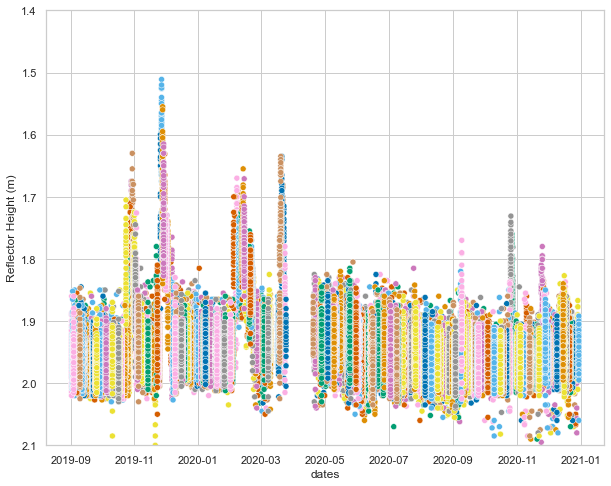

In [42]:
import matplotlib.pyplot as plt

def read_allRH_file(filepath, regex):
    data = {'dates': [], 'rh': []}
    #read daily average reflector heights
    with open(f'{refl_code_dir}{filepath}', 'r') as myfile:
        file = myfile.read()
        matches = re.finditer(regex, file, flags=re.MULTILINE)

        for match in matches:
            ydoy = f'{int(match.group("year"))}-{int(match.group("doy"))}'
            date = datetime.strptime(ydoy, '%Y-%j').date()
            data['dates'].append(date)
            data['rh'].append(float(match.group('rh')))
            
    return data

regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}_allRH.txt'
data = read_allRH_file(filepath, regex)

df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])
plt.figure(figsize=(10,8))
g = sns.scatterplot(x='dates', y='rh', data=df, hue='dates', palette='colorblind', legend=False)
g.set_ylim(2.1, 1.4)
g.set_ylabel('Reflector Height (m)');

A summary of how many values are being used in the daily average:

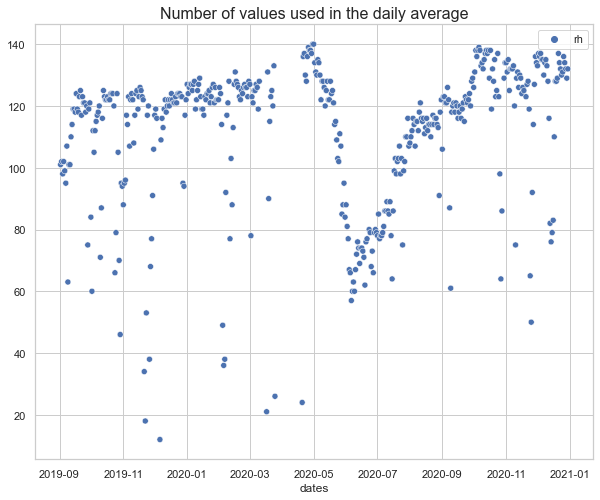

In [43]:
plt.figure(figsize=(10,8))
df_group = df.groupby(['dates']).agg(['count'])
g = sns.scatterplot(data=df_group)
g.set_title('Number of values used in the daily average', size=16);

And the daily RH average:

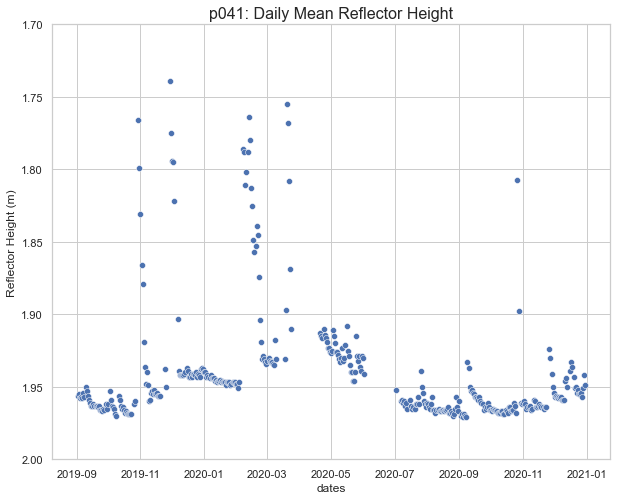

In [48]:
regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}-dailyavg.txt'
data = read_allRH_file(filepath, regex)
df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])

plt.figure(figsize=(10,8))
g = sns.scatterplot(x='dates', y='rh', data=df, legend=False)
g.set_ylim(2,1.7)
g.set_ylabel('Reflector Height (m)')
g.set_title(f'{station}: Daily Mean Reflector Height', size=16);